In [1]:
import numpy as np

In [2]:
## Forward Activations
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

## Backward Activations
def sigmoid_backward(dA, Z):
    sigmoid_Z = sigmoid(Z)
    return dA * sigmoid_Z * (1 - sigmoid_Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <=0] = 0
    return dZ
    
## Initialize Layers
def initialize_layers(network_architecture):
    number_of_layers = len(network_architecture)
    parameters = {}
    
    for index, layer in enumerate(network_architecture):
        layer_index = index + 1
        layer_input_size = layer["input_dimension"]
        layer_output_size = layer["output_dimension"]
        
        ##### remove *0.1  to parameter initialization #####
        parameters['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) *0.1
        parameters['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) *0.1
        
    return parameters

## Forward Propagation

def single_layer_forward_propagation(A_previous, W_current, b_current, activation="relu"):
    Z_current = np.dot(W_current, A_previous) + b_current
    
    if activation is "relu":
        activation_function = relu
    elif activation is "sigmoid":
        activation_function = sigmoid
    else:
        raiseException('Unsupported activation')

    return activation_function(Z_current), Z_current

def full_forward_propagation(X, parameters, network_architecture):
    memory = {}
    A_current = X
    
    for index, layer in enumerate(network_architecture):
        layer_index = index + 1
        A_previous = A_current
        
        activation_function_current = layer["activation"]
        W_current = parameters["W" + str(layer_index)]
        b_current = parameters["b" + str(layer_index)]
        A_current, Z_current = single_layer_forward_propagation(A_previous, W_current, b_current, activation_function_current)

        memory["A" + str(index)] = A_previous
        memory["Z" + str(layer_index)] = Z_current
        
    return A_current, memory

## Loss
def MSE(Y_hat, Y):
    loss = np.square(Y - Y_hat).mean()
    return loss

## Performance Metric
def l2_distance(Y_hat, Y):
    distance = np.sqrt(np.square(Y - Y_hat))
    return distance.mean()

## Backward Propagation
def single_layer_backward_propagation(dA_current, W_current, b_current, Z_current, A_previous, activation="relu"):
    m = A_previous.shape[1]
    
    if activation is "relu":
        backward_activation_function = relu_backward
    elif activation is "sigmoid":
        backward_activation_function = sigmoid_backward
    else:
        raise Exception('Unsupported activation')
        
    dZ_current = backward_activation_function(dA_current, Z_current)
    
    dW_current = np.dot(dZ_current, np.transpose(A_previous)) / m
    db_current = np.sum(dZ_current, axis=1, keepdims=True) / m
    dA_previous = np.dot(np.transpose(W_current), dZ_current)
#     print(dW_current.shape, db_current.shape, dA_previous.shape)
    
    return dA_previous, dW_current, db_current

def full_backward_propagation(Y_hat, Y, memory, parameters, network_architecture):
    gradients = {}
    
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    dA_previous = 2 * (Y_hat-Y)
    
    for layer_index_previous, layer in reversed(list(enumerate(network_architecture))):
        layer_index_current = layer_index_previous + 1
        activation_function_current = layer["activation"]
        
        dA_current = dA_previous
        
        A_previous = memory["A" + str(layer_index_previous)]
        Z_current = memory["Z" + str(layer_index_current)]
        
        W_current = parameters["W" + str(layer_index_current)]
        b_current = parameters["b" + str(layer_index_current)]
        
        dA_previous, dW_current, db_current = single_layer_backward_propagation(dA_current, W_current, b_current, Z_current, A_previous, activation_function_current)
        
        gradients["dW" + str(layer_index_current)] = dW_current
        gradients["db" + str(layer_index_current)] = db_current
        
    return gradients

def update(parameters, gradients, network_architecture, learning_rate):
    
    for layer_index, layer in enumerate(network_architecture,1):
        parameters["W" + str(layer_index)] -= learning_rate * gradients["dW" + str(layer_index)]
        parameters["b" + str(layer_index)] -= learning_rate * gradients["db" + str(layer_index)]
    
    return parameters

def train(X, Y, network_architecture, epochs, learning_rate):
    parameters = initialize_layers(network_architecture)
    loss_history = []
    distance_history = []
    
    for i in range(epochs):
        Y_hat, cache = full_forward_propagation(X, parameters, network_architecture)
        
        loss = MSE(Y_hat, Y)
        loss_history.append(loss)
        
        distance = l2_distance(Y_hat, Y)
        distance_history.append(distance)
        
        gradients = full_backward_propagation(Y_hat, Y, cache, parameters, network_architecture)
        
        parameters = update(parameters, gradients, network_architecture, learning_rate)
        
        print("Iteration: {:02} - loss: {:.5f} - l2-distance: {:.5f}".format(i+1, loss, distance))
        
    return parameters

In [3]:
## Network Architecture
network_architecture = [
    {"input_dimension":1, "output_dimension":64, "activation":"relu"},
    {"input_dimension":64, "output_dimension":64, "activation":"relu"},
    {"input_dimension":64, "output_dimension":1, "activation":"sigmoid"}
]

In [4]:
mean_text = input("Enter Mean:")
mean = float(mean_text)

standard_deviation_text = input("Enter Standard Deviation:")
standard_deviation = float(standard_deviation_text)

number_of_samples = 1000
epochs = 20
learning_rate = 0.1

## Dataset Generation
X = np.random.uniform(mean - 2*standard_deviation, mean + 2*standard_deviation,(1000,1))
Y = (1/(standard_deviation*np.sqrt(2*np.pi))) * np.exp(-0.5*np.square((X - mean)/(standard_deviation)))

X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(number_of_samples):
    if i % 10 == 0:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)



Enter Mean:0
Enter Standard Deviation:1


In [5]:
# Training
parameters = train(np.transpose(X_train), np.transpose(Y_train), network_architecture, epochs, learning_rate)

Iteration: 01 - loss: 0.09253 - l2-distance: 0.28048
Iteration: 02 - loss: 0.08896 - l2-distance: 0.27416
Iteration: 03 - loss: 0.08558 - l2-distance: 0.26803
Iteration: 04 - loss: 0.08237 - l2-distance: 0.26209
Iteration: 05 - loss: 0.07932 - l2-distance: 0.25632
Iteration: 06 - loss: 0.07642 - l2-distance: 0.25073
Iteration: 07 - loss: 0.07368 - l2-distance: 0.24530
Iteration: 08 - loss: 0.07106 - l2-distance: 0.24001
Iteration: 09 - loss: 0.06857 - l2-distance: 0.23489
Iteration: 10 - loss: 0.06623 - l2-distance: 0.23001
Iteration: 11 - loss: 0.06401 - l2-distance: 0.22529
Iteration: 12 - loss: 0.06191 - l2-distance: 0.22071
Iteration: 13 - loss: 0.05990 - l2-distance: 0.21626
Iteration: 14 - loss: 0.05800 - l2-distance: 0.21195
Iteration: 15 - loss: 0.05619 - l2-distance: 0.20775
Iteration: 16 - loss: 0.05447 - l2-distance: 0.20367
Iteration: 17 - loss: 0.05283 - l2-distance: 0.19970
Iteration: 18 - loss: 0.05127 - l2-distance: 0.19583
Iteration: 19 - loss: 0.04977 - l2-distance: 0

In [6]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), parameters, network_architecture)

# Distance achieved on the test set
dist_test = l2_distance(Y_test_hat, np.transpose(Y_test))
print("Test Set Distance: {:.5f}".format(dist_test))


Test Set Distance: 0.17631


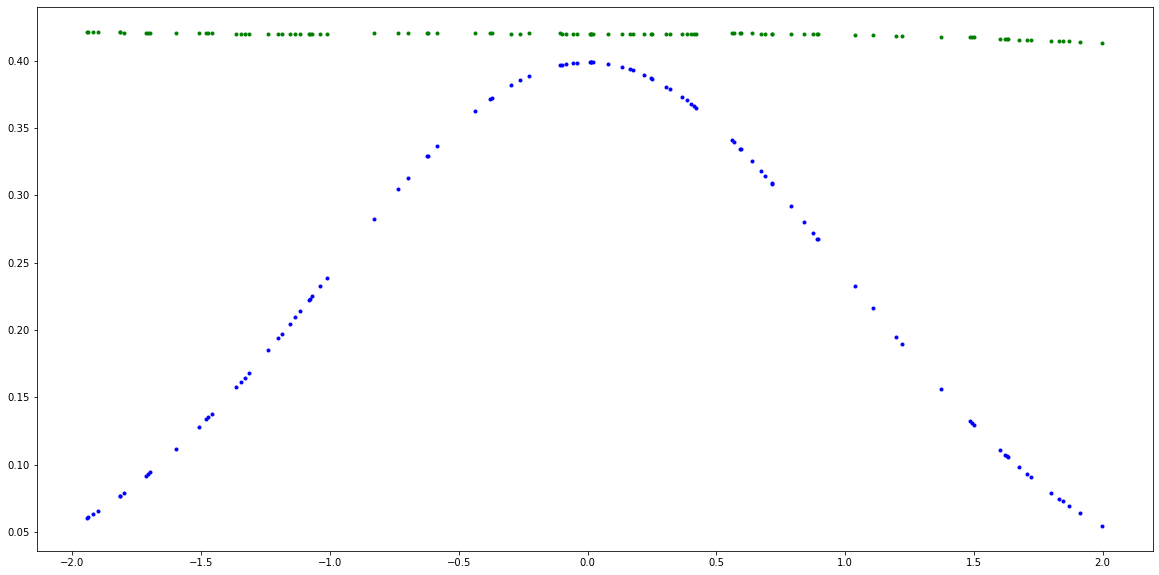

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(X_test,Y_test,'b.')
plt.plot(X_test,np.transpose(Y_test_hat),'g.')
# plt.plot(X_train, Y_train, 'r.')
